In [1]:
import numpy as np
from tqdm.auto import tqdm
from time import time
import copy


import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import *
ratinabox.stylize_plots(); ratinabox.autosave_plots=False; ratinabox.figure_directory = "../figures/"

from ratinabox.contribs.ValueNeuron import ValueNeuron

%load_ext autoreload
%autoreload 2

(<Figure size 500x500 with 2 Axes>, array([<Axes: >], dtype=object))

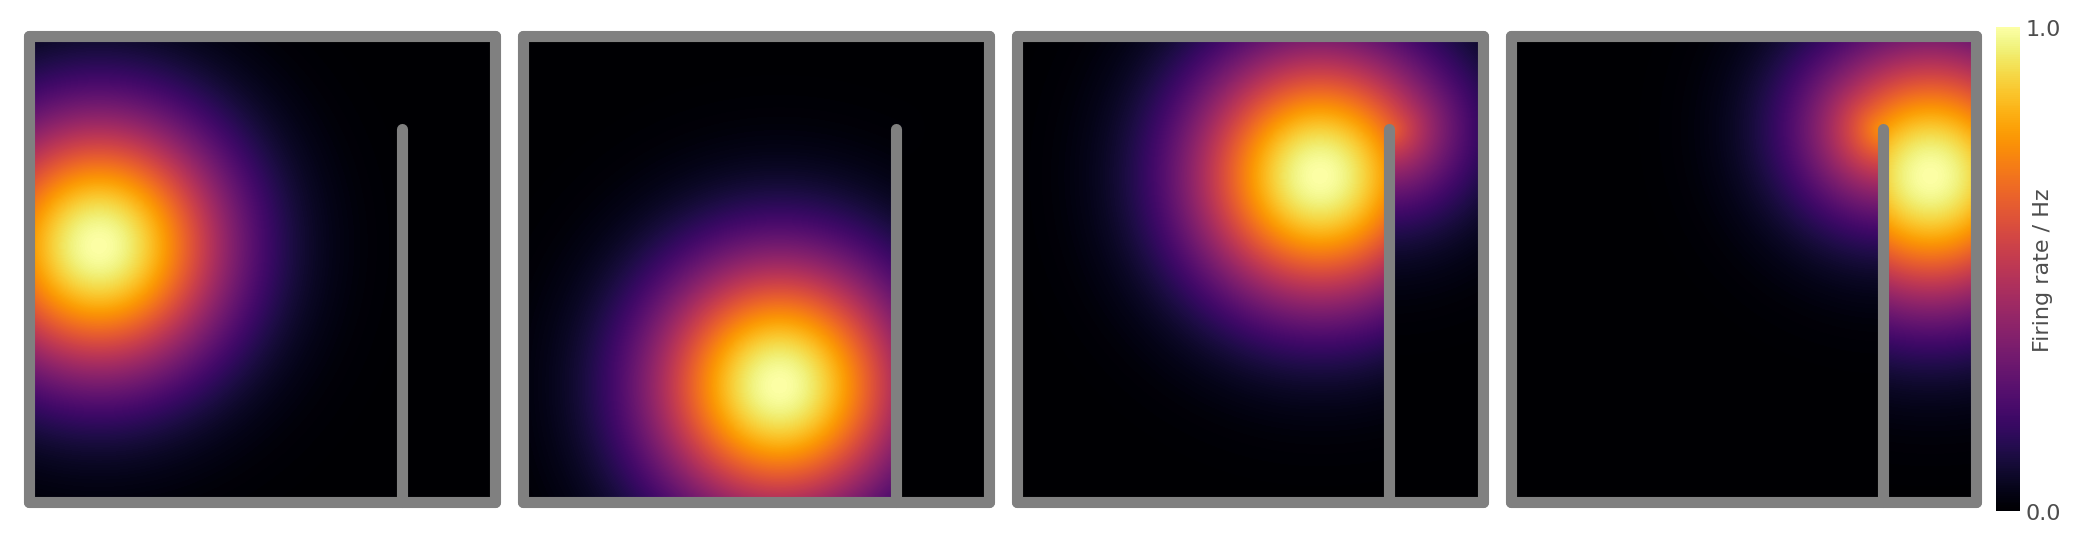

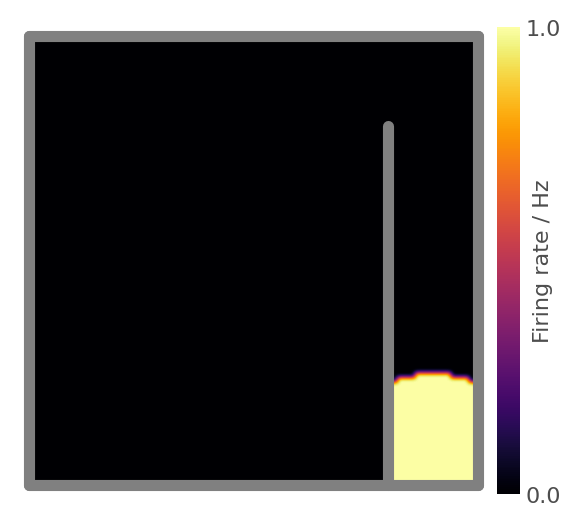

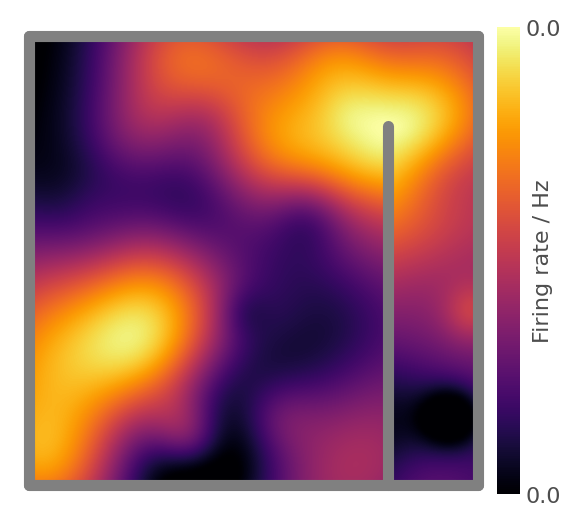

In [ ]:
# Make the environment
Env = Environment()
Env.add_wall([[0.8, 0.0], [0.8, 0.8]])

# Make the agent 
Ag = Agent(Env)
Ag.dt = 50e-3  # set discretisation time, large is fine
Ag.episode_data = {
    "start_time": [],
    "end_time": [],
    "start_pos": [],
    "end_pos": [],
    "success_or_failure": [],
}  # a dictionary we will use later
Ag.exploit_explore_ratio = 0.3  # exploit/explore parameter we will use later


#Input features (200 place cells of random widths)
n_pc = 200 
Inputs = PlaceCells(
    Ag,
    params={
        "n": n_pc,
        "widths": np.random.uniform(0.04, 0.4, size=(n_pc)), #large and small widths
        "color": "C1",
    },
)
# just manually setting the last four cell's widths and locations for some plots I wish to make later, this is not critical
Inputs.place_cell_widths[-4:] = 0.2
Inputs.place_cell_centres[-4:] = np.array(
    [[0.15, 0.55], [0.55, 0.25], [0.65, 0.7], [0.9, 0.7]]
)
Inputs.plot_rate_map(chosen_neurons=[-4, -3, -2, -1], autosave=False)


#The reward neuron (another place cell hidden behind the barrier) 
Reward = PlaceCells(
    Ag,
    params={
        "n": 1,
        "place_cell_centres": np.array([[0.9, 0.05]]),
        "description": "top_hat",
        "widths": 0.2,
        "max_fr": 1,
        "color": "C5",
    },
)
Reward.episode_end_time = 3  # a param we will use later
Reward.plot_rate_map(chosen_neurons="1")



# The Value Neuron
# Now initialise a Value neuron, full documentation of this class in ratinabox/contribs/ValueNeuron.py
# It's a feedforward layer summing (then non-linearly activating) its input features. 
# It takes: 
# • a list of inputs (the place cells we just made) 
# • a timescale for the discounting of future rewards (tau)
# • a non-linear activation function (relu)
ValNeur = ValueNeuron(
    Ag, params={
                "input_layers": [Inputs], 
                "tau": 10,
                "eta":0.001,
                "L2": 0.1,  # L2 regularisation
                "activation_function": {"activation": "relu"}, #can try with relu, tanh, softmax etc. see ratinabox/utils.py: activate() for list
                "color": "C2"}
)
ValNeur.inputs['PlaceCells']['w'] *= 0.01
ValNeur.max_value = np.max(ValNeur.get_state(evaluate_at='all')) #to be periodically updated, a scale for how "big" the vf is so we know where the threshold
ValNeur.plot_rate_map(chosen_neurons="1")

In [3]:
# a function which takes a value neuron and a position and returns the direction of steepest ascent of the value function at that position
def get_steep_ascent(ValueNeuron, pos):
    """This function will be used for policy improvement. Calculates direction steepest ascent (gradient) of the value function and returns a drift velocity in this direction. Returns None when the local gradient is exceedingly low"""
    V = ValueNeuron.get_state(evaluate_at=None, pos=pos)[0][0] #query the firing rate at the given position
    if V <= 0.05*ValueNeuron.max_value:
        return None # if the value function is too low it is unreliable, return None
    else:  # calculate gradient locally
        V_plusdx = ValueNeuron.get_state(evaluate_at=None, pos=pos + np.array([1e-3, 0]))[0][0]
        V_plusdy = ValueNeuron.get_state(evaluate_at=None, pos=pos + np.array([0, 1e-3]))[0][0]
        gradV = np.array([V_plusdx - V, V_plusdy - V])
        norm = np.linalg.norm(gradV)
        gradV = gradV / norm
        return gradV

In [4]:
def do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=True, max_t=60):
    """
    Runs an "episode" of the agent moving around the environment. The agents policy is guided by the value function of the ref_ValNeur (approximately equivalent the epislon greedy). Meanwhile the value function of valNeur is being trained on the (greedy) policy.
    
    ref_ValNeur: the fixed reference value function used for getting the drift velocity
    ValNeur: the value function being trained
    Ag: the agent
    Inputs: the input features
    Reward: the reward neuron
    train: whether to train the value function or not
    max_t: the maximum time the episode can run for before timeout"""
    
    #save start time and position
    Ag.episode_data["start_time"].append(Ag.t)
    Ag.episode_data["start_pos"].append(Ag.pos)

    #resets to zero the eligibility trace and the td error ready for a new episode 
    ValNeur.reset() 

    while True:
        #get greedy direction of steepest ascent of the value function
        gradV = get_steep_ascent(ref_ValNeur, Ag.pos)
        if gradV is None: drift_velocity = None #if None, the agent will just randomly explore
        else: drift_velocity = 3 * Ag.speed_mean * gradV
        # you can ignore this (force agent to travel towards reward when v nearby) helps stability.
        if (Ag.pos[0] > 0.8) and (Ag.pos[1] < 0.4):
            dir_to_reward = Reward.place_cell_centres[0] - Ag.pos
            drift_velocity = (
                3 * Ag.speed_mean * (dir_to_reward / np.linalg.norm(dir_to_reward))
            )

        # move the agent
        Ag.update(
            drift_velocity=drift_velocity,
            drift_to_random_strength_ratio=Ag.exploit_explore_ratio,
        )
        # update inputs and train weights
        Inputs.update() #adapt for prnn
        Reward.update()
        ValNeur.update()
        # train the weights
        if train == True:
            ValNeur.update_weights(reward = Reward.firingrate)
        # end episode when at some random moment when reward is high OR after timeout
        if np.random.uniform() < Ag.dt * Reward.firingrate / Reward.episode_end_time:
            Ag.exploit_explore_ratio *= 1.1  # policy gets greedier if it was successful
            Ag.episode_data["success_or_failure"].append(1)
            break
        if (Ag.t - Ag.episode_data["start_time"][-1]) > max_t:  # timeout
            Ag.episode_data["success_or_failure"].append(0)
            break
    Ag.episode_data["end_time"].append(Ag.t)
    Ag.episode_data["end_pos"].append(Ag.pos)
    Ag.exploit_explore_ratio = max(0.1, min(1, Ag.exploit_explore_ratio)) #keep between 0.1 and 1
    Ag.velocity = np.random.uniform(-0.1, 0.1, size=(2,))
    return

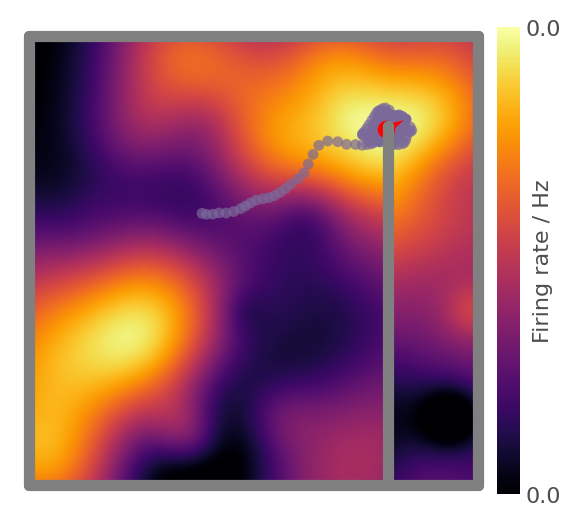

In [5]:
Ag.exploit_explore_ratio = 1 # set this high so agent climbs the VF
do_episode(ValNeur=ValNeur, ref_ValNeur=ValNeur, Ag=Ag, Inputs=Inputs, Reward=Reward, train=False, max_t=60)
fig, ax = ValNeur.plot_rate_map()
fig, ax = Ag.plot_trajectory(fig=fig,ax=ax[0])

In [6]:
Ag.exploit_explore_ratio = (
    0.2  # mostly random exploration to start, this will increase with time
)

batches = 10
episodes_per_batch = 10

for i in (pbar := tqdm(range(batches))):
    pbar.set_description(f"Batch {i+1}/{batches}")
    # cache copy of the ValueNeuron and use this to dictate policy
    ref_ValNeur = copy.deepcopy(ValNeur)
    ref_ValNeur.max_value = np.max(ref_ValNeur.get_state(evaluate_at="all"))
    # ref_ValNeur.max_fr = np.max(ValNeur.get_state(evaluate_at="all"))

    for j in range(episodes_per_batch):  # batches of episodes
        Ag.pos = Env.sample_positions(n=1)[0]  # put agent in random position
        do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=True)
        

    n_success = sum(Ag.episode_data["success_or_failure"][-episodes_per_batch:])
    av_episode_time = np.mean(
        np.array(Ag.episode_data["end_time"][-episodes_per_batch:])
        - np.array(Ag.episode_data["start_time"][-episodes_per_batch:])
    )
    print(
        f"Batch {i+1}/{episodes_per_batch}: {episodes_per_batch-n_success} timeouts, {n_success} successes, average episode time {av_episode_time:.2f}s"
    )

  0%|          | 0/10 [00:00<?, ?it/s]

Batch 1/10: 9 timeouts, 1 successes, average episode time 54.71s
Batch 2/10: 6 timeouts, 4 successes, average episode time 46.65s
Batch 3/10: 0 timeouts, 10 successes, average episode time 14.79s
Batch 4/10: 0 timeouts, 10 successes, average episode time 8.23s
Batch 5/10: 0 timeouts, 10 successes, average episode time 12.37s
Batch 6/10: 0 timeouts, 10 successes, average episode time 8.28s
Batch 7/10: 0 timeouts, 10 successes, average episode time 9.37s
Batch 8/10: 0 timeouts, 10 successes, average episode time 11.30s
Batch 9/10: 0 timeouts, 10 successes, average episode time 10.45s
Batch 10/10: 0 timeouts, 10 successes, average episode time 11.66s


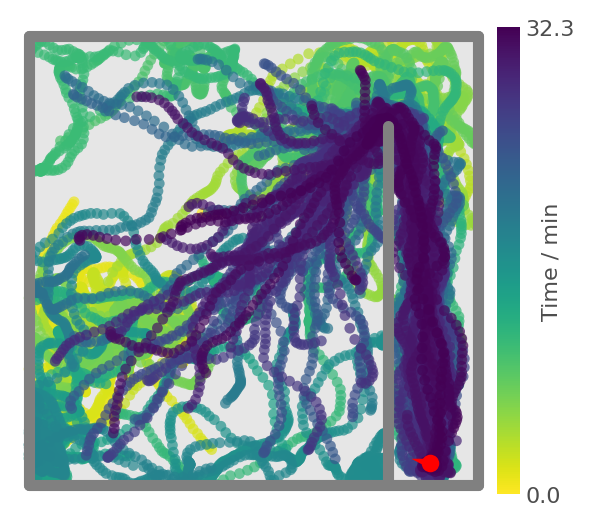

In [7]:
fig, ax = Ag.plot_trajectory(t_start=Ag.episode_data['start_time'][0], 
                             t_end  =Ag.episode_data['end_time'][-1],
                             color='changing',
                             colorbar=True,)

(<Figure size 500x500 with 2 Axes>, array([<Axes: >], dtype=object))

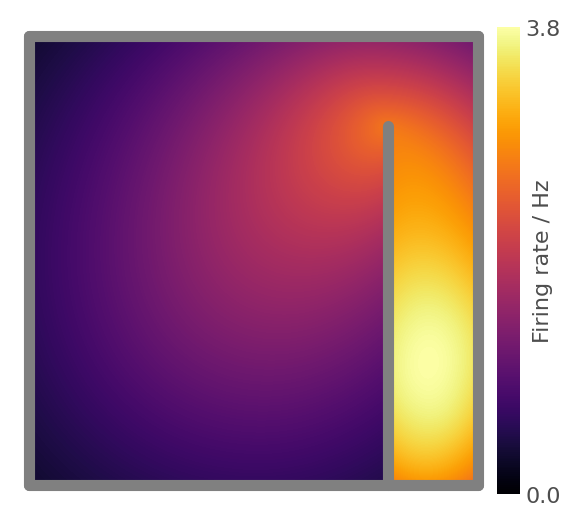

In [8]:
ValNeur.plot_rate_map()

Batch 10/10: 0 timeouts, 8 successes, average episode time 12.47s


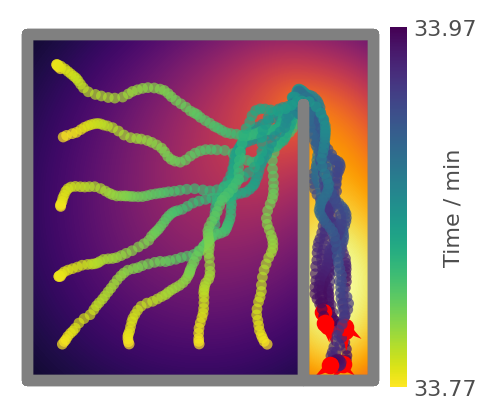

In [9]:
test_pos = np.array(
    [
        [0.1, 0.9],
        [0.1, 0.7],
        [0.1, 0.5],
        [0.1, 0.3],
        [0.1, 0.1],
        [0.3, 0.1],
        [0.5, 0.1],
        [0.7, 0.1],
    ]
)
# test_pos += np.random.uniform(-0.05, 0.05, size=test_pos.shape)
np.random.shuffle(test_pos)
Env.walls[-1, -1, -1] = 0.8
Reward.episode_end_time = 1
for j in range(8):
    Ag.pos = test_pos[j]
    do_episode(ref_ValNeur, ValNeur, Ag, Inputs, Reward, train=False)
n_success = sum(Ag.episode_data["success_or_failure"][-8:])
av_episode_time = np.mean(
    np.array(Ag.episode_data["end_time"][-8:])
    - np.array(Ag.episode_data["start_time"][-8:])
)
print(
    f"Batch {i+1}/{10}: {8-n_success} timeouts, {n_success} successes, average episode time {av_episode_time:.2f}s"
)

Ag.average_measured_speed = 0.15
fig, ax = ValNeur.plot_rate_map(colorbar=False,autosave=False)
for i in range(8):
    fig, ax[0] = Ag.plot_trajectory(
        fig=fig, ax=ax[0], t_start=Ag.episode_data["start_time"][-8+i] + Ag.dt, t_end=Ag.episode_data["end_time"][-8+i], color='changing', colorbar=(i==7), autosave=False
    )
#ratinabox.utils.save_figure(fig, "rl_example_trajectory")
# start_pos = np.array(Ag.episode_data["start_pos"][-8:])
# end_pos = np.array(Ag.episode_data["end_pos"][-8:])
# ax[0].scatter(
    # start_pos[:, 0], start_pos[:, 1], s=20, c="C2", zorder=11, alpha=0.8, linewidths=0
# )
# ax[0].scatter(
    # end_pos[-8:, 0], end_pos[-8:, 1], s=20, c="r", zorder=11, alpha=0.8, linewidths=0
# )